In [1]:
%load_ext autoreload
%autoreload 2
import netCDF4
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants, split_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test, calculate_global_class_weights
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset, MultiXArrayDataset, MultiXArrayProbaDataset
from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix
from hmpai.pytorch.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from hmpai.pytorch.correlation import *
# from braindecode.models.eegconformer import EEGConformer
from mne.io import read_info
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))
from hmpai.visualization import plot_predictions_on_epoch
from hmpai.behaviour.sat2 import read_behavioural_info

In [47]:
set_global_seed(42)
data_path_1 = DATA_PATH / "sat2/stage_data_proba_250hz_part1.nc"
data_path_2 = DATA_PATH / "sat2/stage_data_proba_250hz_part2.nc"
data_paths = [data_path_1, data_path_2]
# train_percentage=100 makes test and val 100 as well
splits = split_participants(data_paths, train_percentage=60)
labels = SAT_CLASSES_ACCURACY
whole_epoch = True
info_to_keep = ['event_name', 'participant', 'epochs']
subset_cond = None # 'speed'|'accuracy'|None
skip_samples = 62
cut_samples = 63

In [48]:
norm_fn = norm_mad_zscore
statistics = {
    "global_min": -0.00014557216,
    "global_max": 0.00014740844,
    "global_mean": -2.277374212336032e-18,
    "global_std": 3.3968840765876904e-06,
    "global_median": 3.4879516e-11,
    "mad_score": 3.2237037e-06,
    "class_weights": Tensor([0.0, 0.0, 0.0, 0.0, 0.0]),
}
norm_vars = get_norm_vars_from_global_statistics(statistics, norm_fn)

train_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[0],
    normalization_fn=norm_fn,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    statistics=statistics,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)
class_weights = train_data.statistics["class_weights"]
test_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[1],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)
val_data = MultiXArrayProbaDataset(
    data_paths,
    participants_to_keep=splits[2],
    normalization_fn=norm_fn,
    norm_vars=norm_vars,
    whole_epoch=whole_epoch,
    labels=labels,
    info_to_keep=info_to_keep,
    subset_cond=subset_cond,
    skip_samples=skip_samples,
    cut_samples=cut_samples,
)

In [49]:
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")
test_loader_sat2 = DataLoader(
    test_data, batch_size=128, shuffle=True, num_workers=8, pin_memory=True
)

In [50]:
chk_path = Path("../../models/mamba_conv_jitter_both_ac.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "embed_dim": 128,
    "n_channels": 19,
    "n_classes": len(labels),
    "n_layers": 5,
    "global_pool": False,
    "dropout": 0.1,
}
model = MambaModel(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)
model.eval();

In [51]:
# SAT2
torch.cuda.empty_cache()

window_size = 0
amount_of_graphs = 5
counter = 0
n_shuffles = 5
target_length = 100

speed_pred = torch.zeros((target_length, len(labels)))
speed_true = torch.zeros((target_length, len(labels)))
accuracy_pred = torch.zeros((target_length, len(labels)))
accuracy_true = torch.zeros((target_length, len(labels)))

n_speed = 0
n_accuracy = 0

with torch.no_grad():
    for batch in test_loader_sat2:
        info = batch[2][0]
        
        # Predict on batch
        pred = model(batch[0].to(DEVICE))
        pred = torch.nn.Softmax(dim=2)(pred).to('cpu')
        true = batch[1]

        lengths = get_masking_indices(batch[0])

        for i in range(pred.shape[0]):
            is_speed = 'speed' in info['event_name'][i]
            pred_epoch = pred[i,:lengths[i]].permute(1, 0).unsqueeze(0)
            true_epoch = true[i,:lengths[i]].permute(1, 0).unsqueeze(0)

            pred_normalized = torch.nn.functional.interpolate(pred_epoch, size=target_length, mode='linear', align_corners=False)
            true_normalized = torch.nn.functional.interpolate(true_epoch, size=target_length, mode='linear', align_corners=False)
            pred_normalized = pred_normalized / pred_normalized.sum(dim=2, keepdim=True)

            # pred_normalized *= lengths[i] / 100
            true_normalized *= lengths[i] / 100
            
            # Additionally normalize over sum to create a valid probability distribution

            pred_normalized = pred_normalized.squeeze().permute(1, 0)
            true_normalized = true_normalized.squeeze().permute(1, 0)

            if is_speed:
                speed_pred += pred_normalized
                speed_true += true_normalized
                n_speed += 1
            else:
                accuracy_pred += pred_normalized
                accuracy_true += true_normalized
                n_accuracy += 1
    
speed_pred /= n_speed
speed_true /= n_speed
accuracy_pred /= n_accuracy
accuracy_true /= n_accuracy

In [27]:
accuracy_pred[:,3].sum()

tensor(1.9655)

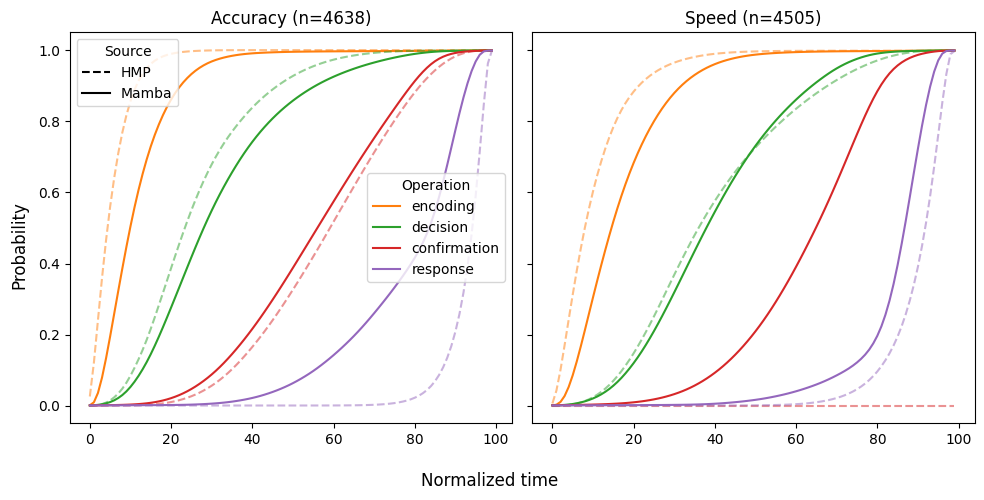

In [59]:
from hmpai.visualization import set_seaborn_style
import matplotlib.pyplot as plt
import seaborn as sns

# fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)
# ax[0, 0].set_ylabel("HMP")
# ax[1, 0].set_ylabel("Model")
# ax[0, 0].set_title(f"Accuracy (n={n_accuracy})")
# ax[0, 1].set_title(f"Speed (n={n_speed})")
# fig.supylabel('Probability')
# fig.supxlabel('Normalized time')
# set_seaborn_style()
# ax_mapping = {0: ax[0, 0], 1: ax[1, 0], 2: ax[0, 1], 3: ax[1, 1]}
# for i_data, data in enumerate([accuracy_true, accuracy_pred, speed_true, speed_pred]):
#     for i, label in enumerate(labels[1:]):
#         sns.lineplot(data[:, i + 1], ax=ax_mapping[i_data], label=label, color=sns.color_palette()[i + 1])
# plt.plot()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.supylabel('Probability')
fig.supxlabel('Normalized time')

ax[0].set_title(f"Accuracy (n={n_accuracy})")
ax[1].set_title(f"Speed (n={n_speed})")

for i, label in enumerate(labels):
    if i == 0:
        continue
    sns.lineplot(accuracy_true[:, i].cumsum(dim=0), ax=ax[0], label=label, color=sns.color_palette()[i], linestyle="--", alpha=0.5)
    sns.lineplot(accuracy_pred[:, i].cumsum(dim=0), ax=ax[0], label=label, color=sns.color_palette()[i], linestyle="-")

    sns.lineplot(speed_true[:, i].cumsum(dim=0), ax=ax[1], label=label, color=sns.color_palette()[i], linestyle="--", alpha=0.5)
    sns.lineplot(speed_pred[:, i].cumsum(dim=0), ax=ax[1], label=label, color=sns.color_palette()[i], linestyle="-")

handles, ax_labels = ax[0].get_legend_handles_labels()
label_legend = ax[0].legend(handles=handles[1::2], labels=ax_labels[1::2], title="Operation")

# ax[1].legend(handles=handles, labels=ax_labels, title="Labels")
custom_lines = [
    plt.Line2D([0], [0], color='black', linestyle='--'),   # Solid line
    plt.Line2D([0], [0], color='black', linestyle='-')  # Dashed line
]

# ax[0].legend(custom_lines, ['HMP', 'Mamba'], loc='upper right', title="Line Style")
line_legend = ax[0].legend(custom_lines, ['HMP', 'Mamba'], loc='upper left', title="Source")
ax[0].add_artist(label_legend)
plt.legend([], [], frameon=False)

# ax[0].add_artist(line_legend)

plt.tight_layout()
plt.show()